# <h3><center>Covid_19 project</center></h3>
<h3><center>Le Hoang Viet, Antoine Branchoux, Liang Hu, Hongxia Tang - M2 FTD</center></h3>

## Structure

### 1. Introduction 
### 2. Importing library
### 3. Data collection
   ####  3.1. Stock data collection
   ####  3.2. Contextualweb news collection
### 4. Data Analysis
   #### 4.1. Function of data analysis
   ##### 4.1.1. By each stock
   ##### 4.1.2. By each group of news
   #### 4.2. Analysis based only on news happended during the trading time.
   ##### 4.2.1. CAR for each stock
   ###### 4.2.1.1. CAR of positive news
   ###### 4.2.1.2. CAR of negative news
   ###### 4.2.1.3. CAR of neutral news
   ##### 4.2.2. CAR for poeitive, negative or neutral news
   ##### 4.2.3. CAR by goup of news
   #### 4.3. Analysis based on all news
   ##### 4.3.1. CAR for each stock
   ###### 4.3.1.1 CAR of positive news
   ###### 4.3.1.2. CAR of negative news
   ###### 4.3.1.3. CAR of neutral news
   ##### 4.3.2. CAR for positive, negative or neutral news
   ##### 4.3.3. CAR by group of news
### 5. Conclusion
### Reference

# 1. Introduction

In this notebook, we try to find the release of related news about covid-19 treatment medicine have impact on the drug's stock price or not. 

## 1.1. Data: 
**News data**: We tried to get news through NewSearchApi from 2020-01-01 to 2020-05-01, for the listed 7 different drug's news: **1. Nicotine** (3 news).  **2. Novavax**(5 news). **3. Galidesivir**(2 news). **4. AbbVie**(6 news). **5. Remdesivir**(20 news). **6.Chloroquine**(40 news). **7. Regeneron**(6 news).

**Stock data**: We use two types of data. 1. tabacco companies stocks: 'mo','bats','rai','sdi','tpb','japaf','ctobf','sndvf','bti','btaff'. 2. pharmacy companies stocks: 'gild','jnj','pfe','abbv','mrk','abt','spy','nvax','sny','regn','bcrx'






# 2. Importing library

In [ ]:
!pip install gspread-pandas
!pip3 install pymongo[srv]

     |████████████████████████████████| 194kB 8.1MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime as dt
import os
import time
import re
import copy

import matplotlib.pyplot as plt

import warnings

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


from datetime import timedelta
from pymongo import MongoClient

import statsmodels.api as sm

import statsmodels.formula.api as smf
# from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.graphics.tsaplots import plot_acf
# from statsmodels.graphics.tsaplots import plot_pacf
# from statsmodels.tsa.stattools import adfuller
# import matplotlib.pyplot as plt

# from statsmodels.tsa.api import VAR

os.chdir('/content/drive/My Drive/Alternance/S2 Thomas project Covid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 3. Data collection

## 3.1. Stock data collection
We use tiingo api to get our two types of stock data. As we introduced before, two types of companies are collected by us, 10 tobacco's company stock and and 11 pharmacy stock.

In [ ]:
client = MongoClient('mongodb+srv://<account>:<password>@cluster0-sqhg2.mongodb.net/test?retryWrites=true&w=majority')
token='[INSERT TIINGO API TOKEN]'
headers = {
    'Content-Type': 'application/json'
}

tobacco=['mo','bats','rai','sdi','tpb','japaf','ctobf','sndvf','bti','btaff']
         
pharma=['gild','jnj','pfe','abbv','mrk','abt','spy','nvax','sny','regn','bcrx']

db=client['Tobacco']
for stocki in tqdm(tobacco):
    requestResponse = requests.get("https://api.tiingo.com/iex/{}/prices?startDate=2019-01-02&resampleFreq=5min&token={}".format(stocki,token), headers=headers)
    data_json=requestResponse.json()
    data=json_normalize(data_json)
    data.to_csv('{}.csv'.format(stocki),index=False)
    for element in data_json:
        insert_element = {"TimeStamp": element["date"], 
                          "close": element["close"], 
                          "high": element["high"], 
                          "low": element["low"],
                          "open": element["open"],
                          }
        try:
            result = db['{}'.format(stocki)].insert_one(insert_element)
        except:
            break

db=client['Pharma']
for stocki in tqdm(pharma):
    requestResponse = requests.get("https://api.tiingo.com/iex/{}/prices?startDate=2019-01-02&resampleFreq=5min&token={}".format(stocki,token), headers=headers)
    data_json=requestResponse.json()
    data=json_normalize(data_json)
    data.to_csv('{}.csv'.format(stocki),index=False)
    for element in data_json:
            insert_element = {"TimeStamp": element["date"], 
                              "close": element["close"], 
                              "high": element["high"], 
                              "low": element["low"],
                              "open": element["open"],
                              }
            try:
                result = db['{}'.format(stocki)].insert_one(insert_element)
            except:
                break

## 3.2. Contextualweb news collection
Here we use NewsSearchAPI to collect our related news from 2020-01-01 to 2020-05-05. And then we manually check every news in our spreadsheet. 

In [ ]:
db=client['Contextualweb']

url = "https://contextualwebsearch-websearch-v1.p.rapidapi.com/api/Search/NewsSearchAPI"

query='(tobacco or nicotine) and covid-19'

for pgnum in tqdm(range(1,7)):
    querystring = {"fromPublishedDate":"01-01-2020","toPublishedDate":"05-05-2020","autoCorrect":"false","pageNumber":"{}".format(pgnum),"pageSize":"50","q":"{}".format(query),"safeSearch":"false"}

    headers = {
        'x-rapidapi-host': "contextualwebsearch-websearch-v1.p.rapidapi.com",
        'x-rapidapi-key': "[INSERT RAPIDAPI API TOKEN HERE]"
        }
#     try:
    response = requests.request("GET", url, headers=headers, params=querystring)
    data=response.json()
    for element in data["value"]:
        insert_element = {"Title": element["title"], 
                          "TimeStamp": element["datePublished"], 
                          "Provider": element["provider"]["name"], 
                          "URL": element["url"], 
                          "Description": element["description"],
                          "Content": element["body"],
                          "Keywords": element["keywords"], 
                          "Language": element["language"]
                         }
#         print(insert_element)
        try:
            result = db['{}'.format(query)].insert_one(insert_element)
        except:
            continue


# 4. Data analysis


## 4.1. Function for data analysis
Here we make different functions to analyse the relationship between stock return and news release in different ways.

### 4.1.1. By each stock
We categorize our news into 3 different types. **Positive**(the release of news have pisitive impact on stock return). **Negative**(the release of news have negative impact on stock return). **Neutral**(the release of news have no impact on stock return).

In [ ]:
def get_CAR(begin_time,end_time,symbol,local_news=True,time_before=20,time_after=20,intra_only=False):
  stock_twits_symbol_list=['GILD','REGN','ABBV','ABT','BCRX','BTI','PM','MO','TPB','NVAX','SNY']
  stock_data_list=['gild','regn','abbv','abt','bcrx','bti','pm','mo','tpb','nvax','sny']
  news_file_list=['remdesivir','regeneron','abbv','chloroquine','Biocryst','tobacco','tobacco','tobacco','tobacco','nvax','chloroquine']
  
  news=pd.read_csv('data/{}_news.csv'.format(news_file_list[stock_twits_symbol_list.index(symbol)]))
  news.set_index('TimeStamp',inplace=True)
  news.index=pd.to_datetime(news.index)
  news_pos=news[(news['Sent']==1)&(news['US']==local_news)].resample('5Min').count()
  news_neg=news[(news['Sent']==-1)&(news['US']==local_news)].resample('5Min').count()
  news_neu=news[(news['Sent']==0)&(news['US']==local_news)].resample('5Min').count()
  news=news.resample('5Min').count()

  price=pd.read_csv('data/{}.csv'.format(stock_data_list[stock_twits_symbol_list.index(symbol)]))
  price.date=pd.to_datetime(price.date)
  price.set_index('date',inplace=True)
  price.index=price.index.tz_localize(None)
  price['return']=(price.close-price.close.shift(1))/price.close.shift(1)
  price_fill=price['return'].resample('5Min').asfreq(fill_value=0).to_frame()

  index_df=pd.read_csv('data/spy.csv')
  index_df.date=pd.to_datetime(index_df.date)
  index_df.set_index('date',inplace=True)
  index_df.index=index_df.index.tz_localize(None)

  index_filled=index_df['close'].resample('5Min').ffill().to_frame()
  index_filled['return']=(index_filled.close-index_filled.close.shift(1))/index_filled.close.shift(1)

  temp=price_fill['return'].to_frame()

  df=temp[(temp.index>=begin_time) & (temp.index<=end_time) ]
  df['news'] = df.index.to_series().map(news['Title'])
  df['news_pos'] = df.index.to_series().map(news_pos['Title'])
  df['news_neg'] = df.index.to_series().map(news_neg['Title'])
  df['news_neu'] = df.index.to_series().map(news_neu['Title'])


  df.fillna(0,inplace=True)
  
  df['ret_index']=df.index.to_series().map(index_filled['return'])
  df.dropna(inplace=True)

  Y = df['return']
  X = df['ret_index']
  X = sm.add_constant(X)
  model = sm.OLS(Y,X)
  results = model.fit()
  df['exp_ret']=results.params[0]+results.params[1]*df['ret_index']
  df['AR']=df['return']-df['exp_ret']

  CAR_pos=[]
  CAR_neg=[]
  CAR_neu=[]

  AR_list=df['AR'].values
  news_pos_list=df['news_pos'].values
  news_neg_list=df['news_neg'].values
  news_neu_list=df['news_neu'].values

  ret_list=df['return'].values

  time_range=np.arange(-time_before,time_after)*5

  for i in range(time_before,len(df['AR'])-time_after):
    if intra_only:
      if ret_list[i-1]==0 and ret_list[i+1]==0:
        continue
    if news_pos_list[i]==1:
      j=i
      k=i-1
      before_list=[]
      while (len(before_list)<time_before):
        if ret_list[j-1]!=0:
          before_list.append(AR_list[j-1])
          j-=1
        else:
          while (ret_list[j-1]==0):
            j-=1
          before_list.append(AR_list[j-1])
          before_list=before_list[::-1]
      after_list=[]
      while (len(after_list)<time_after):
        if ret_list[k+1]!=0:
          after_list.append(AR_list[k+1])
          k+=1
        else:
          while (ret_list[k+1]==0):
            k+=1
          after_list.append(AR_list[k+1])
      CAR_pos.append(np.cumsum(before_list+after_list))
      # CAR.append(np.cumsum(AR_list[i-time_before:i+time_after]))
    if news_neg_list[i]==1:
      j=i
      k=i-1
      before_list=[]
      while (len(before_list)<time_before):
        if ret_list[j-1]!=0:
          before_list.append(AR_list[j-1])
          j-=1
        else:
          while (ret_list[j-1]==0):
            j-=1
          before_list.append(AR_list[j-1])
          before_list=before_list[::-1]
      after_list=[]
      while (len(after_list)<time_after):
        if ret_list[k+1]!=0:
          after_list.append(AR_list[k+1])
          k+=1
        else:
          while (ret_list[k+1]==0):
            k+=1
          after_list.append(AR_list[k+1])
      CAR_neg.append(np.cumsum(before_list+after_list))
      # CAR.append(np.cumsum(AR_list[i-time_before:i+time_after]))
    if news_neu_list[i]==1:
      j=i
      k=i-1
      before_list=[]
      while (len(before_list)<time_before):
        if ret_list[j-1]!=0:
          before_list.append(AR_list[j-1])
          j-=1
        else:
          while (ret_list[j-1]==0):
            j-=1
          before_list.append(AR_list[j-1])
          before_list=before_list[::-1]
      after_list=[]
      while (len(after_list)<time_after):
        if ret_list[k+1]!=0:
          after_list.append(AR_list[k+1])
          k+=1
        else:
          while (ret_list[k+1]==0):
            k+=1
          after_list.append(AR_list[k+1])
      CAR_neu.append(np.cumsum(before_list+after_list))
      # CAR.append(np.cumsum(AR_list[i-time_before:i+time_after]))
  return CAR_pos, CAR_neg,CAR_neu, news, df   

### 4.1.2. By each group of news

In [ ]:
def get_CAR_group(begin_time,end_time,symbol,group,time_before=20,time_after=20,intra_only=False):
  
  stock_twits_symbol_list=['GILD','REGN','ABBV','ABT','BCRX','BTI','PM','MO','TPB','NVAX','SNY']
  stock_data_list=['gild','regn','abbv','abt','bcrx','bti','pm','mo','tpb','nvax','sny']
  news_file_list=['remdesivir','regeneron','abbv','chloroquine','Biocryst','tobacco','tobacco','tobacco','tobacco','nvax','chloroquine']

  news=pd.read_csv('data/{}_news.csv'.format(news_file_list[stock_twits_symbol_list.index(symbol)]))
  news.set_index('TimeStamp',inplace=True)
  news.index=pd.to_datetime(news.index)
  news=news[news['Group']==group].resample('5Min').count()
  
  price=pd.read_csv('data/{}.csv'.format(stock_data_list[stock_twits_symbol_list.index(symbol)]))
  price.date=pd.to_datetime(price.date)
  price.set_index('date',inplace=True)
  price.index=price.index.tz_localize(None)
  price['return']=(price.close-price.close.shift(1))/price.close.shift(1)
  price_fill=price['return'].resample('5Min').asfreq(fill_value=0).to_frame()

  index_df=pd.read_csv('data/spy.csv')
  index_df.date=pd.to_datetime(index_df.date)
  index_df.set_index('date',inplace=True)
  index_df.index=index_df.index.tz_localize(None)


  index_filled=index_df['close'].resample('5Min').ffill().to_frame()
  index_filled['return']=(index_filled.close-index_filled.close.shift(1))/index_filled.close.shift(1)

  temp=price_fill['return'].to_frame()

  df=temp[(temp.index>=begin_time) & (temp.index<=end_time) ]
  df['news'] = df.index.to_series().map(news['Title'])

  df.fillna(0,inplace=True)
  
  df['ret_index']=df.index.to_series().map(index_filled['return'])
  df.dropna(inplace=True)

  Y = df['return']
  X = df['ret_index']
  X = sm.add_constant(X)
  model = sm.OLS(Y,X)
  results = model.fit()
  df['exp_ret']=results.params[0]+results.params[1]*df['ret_index']
  df['AR']=df['return']-df['exp_ret']

  CAR=[]
  
  AR_list=df['AR'].values
  news_list=df['news'].values
  
  ret_list=df['return'].values

  time_range=np.arange(-time_before,time_after)*5

  for i in range(time_before,len(df['AR'])-time_after):
    if intra_only:
      if ret_list[i-1]==0 and ret_list[i+1]==0:
        continue
    if news_list[i]==1:
      j=i
      k=i-1
      before_list=[]
      while (len(before_list)<time_before):
        if ret_list[j-1]!=0:
          before_list.append(AR_list[j-1])
          j-=1
        else:
          while (ret_list[j-1]==0):
            j-=1
          before_list.append(AR_list[j-1])
          before_list=before_list[::-1]
      after_list=[]
      while (len(after_list)<time_after):
        if ret_list[k+1]!=0:
          after_list.append(AR_list[k+1])
          k+=1
        else:
          while (ret_list[k+1]==0):
            k+=1
          after_list.append(AR_list[k+1])
      CAR.append(np.cumsum(before_list+after_list))
      # CAR.append(np.cumsum(AR_list[i-time_before:i+time_after]))

  return CAR, news, df   

## 4.2. Analysis based only on news happened during the trading time
Here we only focus on the news that release during the trading time in US.

### 4.2.1. CAR for each stock
By changing the symbol value in the symbol list "stock_twits_symbol_list", we can get the CAR of positive, negative and neutral news of that specific stocks.

In [ ]:
begin_time=dt(2020,1,14)
end_time=dt(2020,5,2)
stock_twits_symbol_list=['GILD','REGN','ABBV','ABT','BCRX','BTI','PM','MO','TPB','NVAX','SNY']
symbol='GILD'

time_before=20
time_after=20
time_range=np.arange(-time_before,time_after)*5

CAR_pos,CAR_neg, CAR_neu, news, df = get_CAR(begin_time,end_time,symbol,local_news=True,intra_only=True)

#### 4.2.1.1 CAR of positive news

From the figure we can see below, there are 8 positive news, and among them, 5 news have positive effect on stock return after the news release, and it last not long, so, here we can say the positive news do effect the stock return.

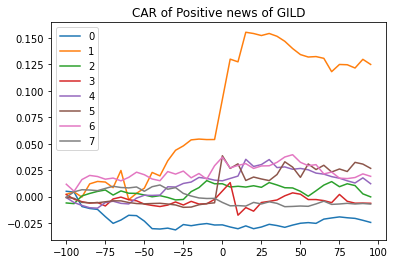

In [ ]:
plt.figure()
for i in range(len(CAR_pos)):
  plt.plot(time_range,CAR_pos[i],label='{}'.format(i))
plt.legend()
plt.title('CAR of Positive news of {}'.format(symbol))
plt.show()

#### 4.2.1.2. CAR of negative news
**Here we have two negative news in the negative news figure below, we can find the orange one has obviously change before the release of news. In some way, the release of news has impact on stock return. For the reason why it changed before the release of news, we think there may have two reasons. Firstly, we unfortunetly not find the initial timestamp of this news. Secondly, there are some inner information released before the news released.**

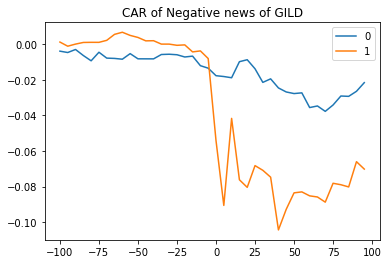

In [ ]:
plt.figure()
for i in range(len(CAR_neg)):
# for i in range(5,10):
  plt.plot(time_range,CAR_neg[i],label='{}'.format(i))
plt.legend()
plt.title('CAR of Negative news of {}'.format(symbol))
plt.show()

#### 4.2.1.3. CAR of neutral news
**There is no figure for the release of neutral news,because here we focus only on the news happend during the trading time.**

No handles with labels found to put in legend.


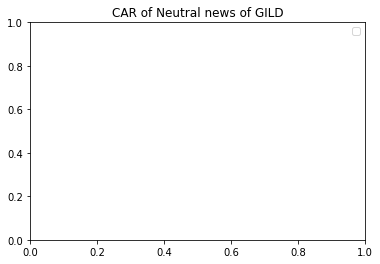

In [ ]:
plt.figure()
for i in range(len(CAR_neu)):
  plt.plot(time_range,CAR_neu[i],label='{}'.format(i))
plt.legend()
plt.title('CAR of Neutral news of {}'.format(symbol))
plt.show()

### 4.2.2. CAR for positive, negative or neutral news
**This part shows the average CAR of all the studied stocks based on positive, negative and neutral news**

In [ ]:
stock_twits_symbol_list=['GILD','REGN','ABBV','ABT','BCRX','BTI','PM','MO','TPB','NVAX','SNY']
begin_time=dt(2020,1,14)
end_time=dt(2020,5,2)
intra_only=True

all_CAR_pos=[]
all_CAR_neg=[]
all_CAR_neu=[]
for symbol in tqdm(stock_twits_symbol_list):
  CAR_pos,CAR_neg, CAR_neu, news, df = get_CAR(begin_time,end_time,symbol,local_news=True,intra_only=intra_only)
  all_CAR_pos = all_CAR_pos + CAR_pos
  all_CAR_neg = all_CAR_neg + CAR_neg
  all_CAR_neu = all_CAR_neu + CAR_neu
all_CAR_pos=np.array(all_CAR_pos)
all_CAR_neg=np.array(all_CAR_neg)
all_CAR_neu=np.array(all_CAR_neu)
mean_CAR_pos = np.mean(all_CAR_pos,axis=0)
mean_CAR_neg = np.mean(all_CAR_neg,axis=0)
mean_CAR_neu = np.mean(all_CAR_neu,axis=0)

100%|██████████| 11/11 [00:01<00:00,  7.45it/s]


**According to the figure below, we can see the release of positive news has positive impact on stock return. The release of negative one has negative impact on stock return and quite surprise that the release of neutral news show negative impact on stock return.** 

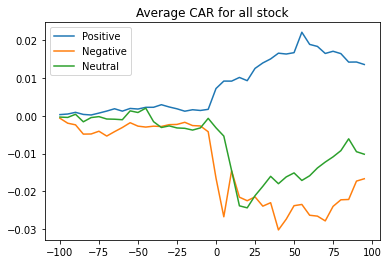

In [ ]:
plt.figure()
plt.plot(time_range,np.mean(all_CAR_pos,axis=0),label='Positive')
plt.plot(time_range,np.mean(all_CAR_neg,axis=0),label='Negative')
plt.plot(time_range,np.mean(all_CAR_neu,axis=0),label='Neutral')
plt.legend()
plt.title('Average CAR for all stock')
plt.show()

### 4.2.3. CAR by group of news
This part shows the CAR of all studied stocks based on each type of news.
Here we categorize the news not by positive negative or neutral, we categorize them by the content of news, so we have group list: **'Trial',  'Approval',  'Positive result',  'Negative result',   'Supply',  'Speculation',  'Side effects',  'Partnership',  'Other'**

In [ ]:
begin_time=dt(2020,1,14)
end_time=dt(2020,5,2)
group_list=['Trial','Approval','Positive result','Negative result','Supply','Speculation','Side effects','Partnership','Other']
stock_twits_symbol_list=['GILD','REGN','ABBV','ABT','BCRX','BTI','PM','MO','TPB','NVAX','SNY']
intra_only=True

def get_plot_group(begin_time,end_time,group,intra_only):
  all_CAR=[]
  for symbol in stock_twits_symbol_list:
    CAR, news, df = get_CAR_group(begin_time,end_time,symbol,group,intra_only=intra_only)
    all_CAR = all_CAR + CAR
  all_CAR=np.array(all_CAR)
  mean_CAR = np.mean(all_CAR,axis=0)
  return all_CAR, mean_CAR 
  

#### Graphs of CAR by each group of news
According to the graph below, we can find:
1. For the release of **trial news**, we have 15 news in this category. three of them have obviously negative effect on stock return, and one have obviously positive effect on stock return ,we can find there are some stocks' return have obviously change after the release of trial news. And this kind of effect last for couple of hours, especially for the purple one.
2. For the release of **Approval news**, we have 9 news in this category. most of them can affect the stock return in a positive way(1 news) or a negative way(5 news).
3. For the release of **positive result news**, we have 5 news in this category. four of them have positive impact on the stock return. the timestamp is not perfectly matched due to some reasons, but we do find it affects the stock return according the third graph below.
4. For the release of **Negative result news**, here we have 3 news in the category, only one news have obviously negative impact on stock return.
5. For the release of **supply news**, there are 2 news in this category, here we can find only one news have obviously negative effect on stock return.
6. For the release of **speclation news**, we have 3 news here. Two of them have obviously positive effect on the stock return.
7. For the release of **side effects news**, we don't have figure here, because it release not during the trading time.
8. For the release of **partnership news**, we don't have figure here, because it release not during the trading time.
9. For the release of **other news**. We have two news here. Both of them have negative effect on stock return. 

  0%|          | 0/9 [00:00<?, ?it/s]

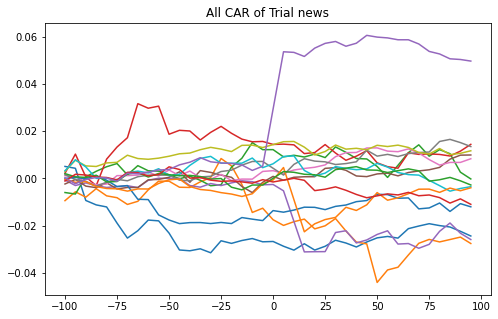

 11%|█         | 1/9 [00:01<00:10,  1.36s/it]

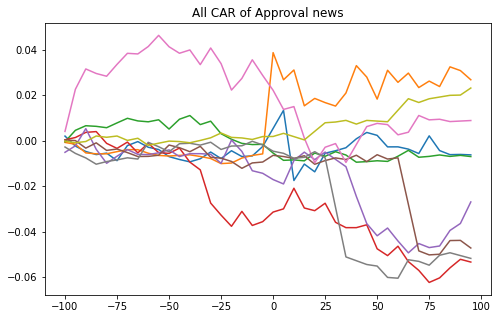

 22%|██▏       | 2/9 [00:02<00:09,  1.39s/it]

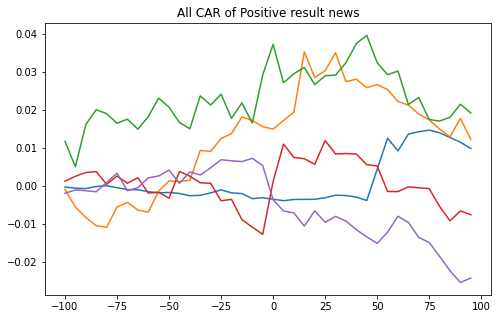

 33%|███▎      | 3/9 [00:04<00:08,  1.39s/it]

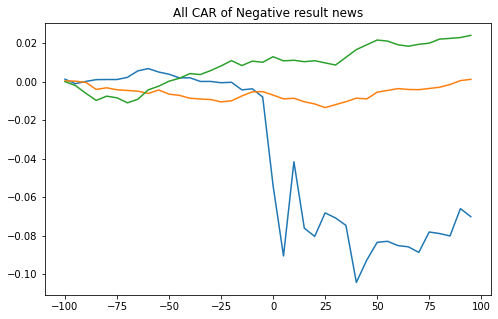

 44%|████▍     | 4/9 [00:05<00:06,  1.38s/it]

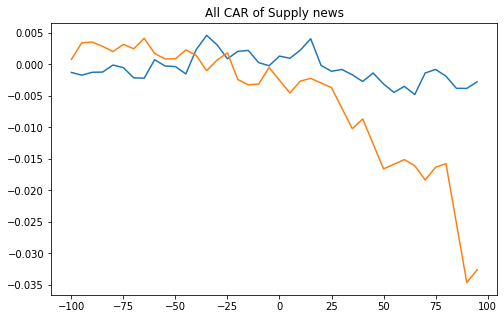

 56%|█████▌    | 5/9 [00:06<00:05,  1.37s/it]

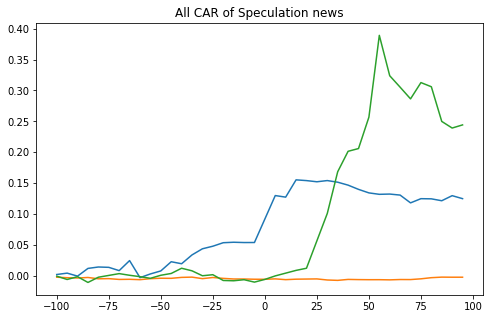

 67%|██████▋   | 6/9 [00:08<00:04,  1.37s/it]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


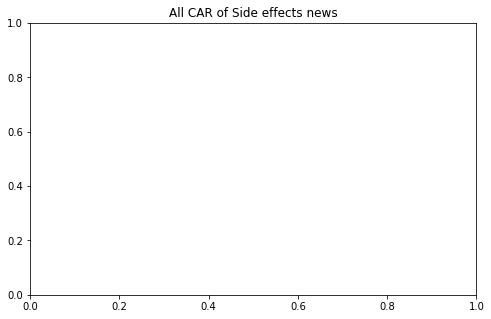

 78%|███████▊  | 7/9 [00:09<00:02,  1.36s/it]

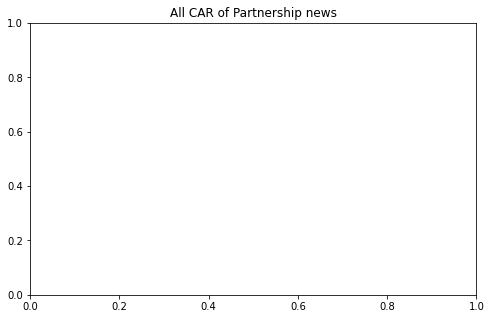

 89%|████████▉ | 8/9 [00:10<00:01,  1.35s/it]

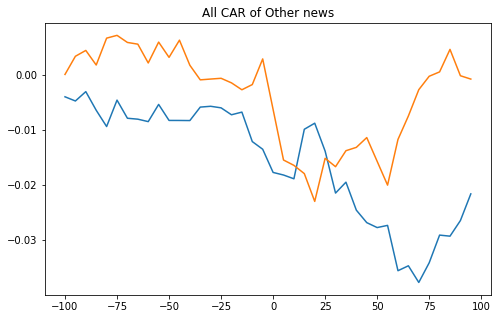

100%|██████████| 9/9 [00:12<00:00,  1.37s/it]


In [ ]:
for group in tqdm(group_list):
  all_CAR, mean_CAR=get_plot_group(begin_time,end_time,group,intra_only=intra_only)
  
  plt.figure(figsize=(8, 5))
  plt.title('All CAR of {} news'.format(group))
  for i in range(len(all_CAR)):
    plt.plot(time_range,all_CAR[i])
  plt.show()


#### Average CAR by each group of news
If we take a look at the average effect of each category news, we can find that the "Speculation" type of news have very obviously positive impact on the stock return. And also for the "negative result" news has negative impact on the stock return.

 67%|██████▋   | 6/9 [00:07<00:03,  1.18s/it]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 78%|███████▊  | 7/9 [00:08<00:02,  1.18s/it]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


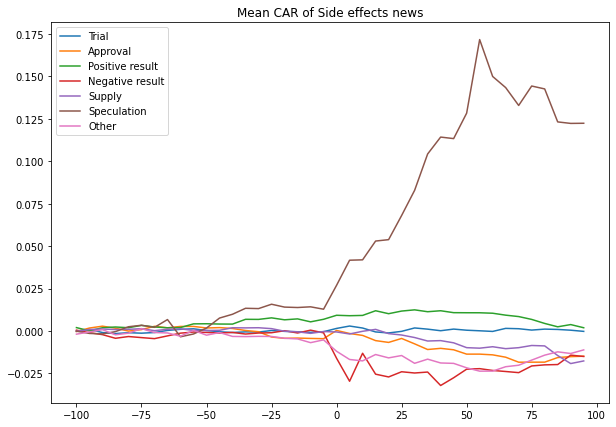

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Mean CAR of {} news'.format(group))
for group in tqdm(group_list):
  all_CAR, mean_CAR=get_plot_group(begin_time,end_time,group,intra_only=intra_only)
  try:  
    plt.plot(time_range,mean_CAR,label='{}'.format(group))
  except:
    pass
plt.legend()
plt.show()

## 4.3. Analysis based on all news
Here we analyse all the news we got, not only the news released during the trading time.

### 4.3.1 CAR for each stock
By changing the symbol value in the symbol list "stock_twits_symbol_list", we can get the CAR of positive, negative and neutral news of that specific stocks.

In [ ]:
begin_time=dt(2020,1,14)
end_time=dt(2020,5,2)
stock_twits_symbol_list=['GILD','REGN','ABBV','ABT','BCRX','BTI','PM','MO','TPB','NVAX','SNY']
symbol='GILD'
intra_only=False

time_before=20
time_after=20
time_range=np.arange(-time_before,time_after)*5

CAR_pos,CAR_neg, CAR_neu, news, df = get_CAR(begin_time,end_time,symbol,local_news=True,intra_only=intra_only)

#### 4.3.1.1 CAR of positive news
Here we have 14 positive news in the figure below, we can find almost all of them have positive effect on stock return.

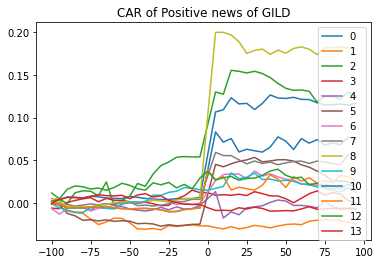

In [ ]:
plt.figure()
for i in range(len(CAR_pos)):
  plt.plot(time_range,CAR_pos[i],label='{}'.format(i))
plt.legend()
plt.title('CAR of Positive news of {}'.format(symbol))
plt.show()

#### 4.3.1.2 CAR of negative news
Here we have 3 negative news in the figure below, 2 news have obviously negative effect on the stock return.

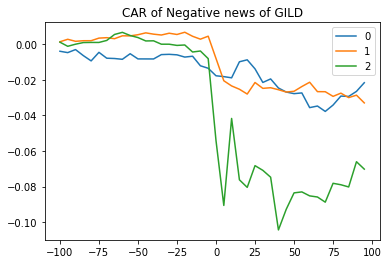

In [ ]:
plt.figure()
for i in range(len(CAR_neg)):
# for i in range(5,10):
  plt.plot(time_range,CAR_neg[i],label='{}'.format(i))
plt.legend()
plt.title('CAR of Negative news of {}'.format(symbol))
plt.show()

#### 4.3.1.3 CAR of neutral news
We have 3 neutral news, and two of them show negative effect on the stock return and one of them show positive effect on the stock return.

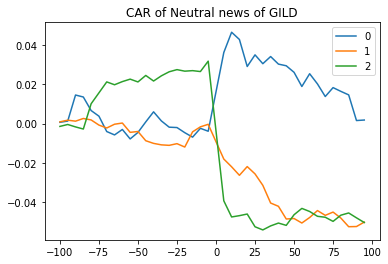

In [ ]:
plt.figure()
for i in range(len(CAR_neu)):
  plt.plot(time_range,CAR_neu[i],label='{}'.format(i))
plt.legend()
plt.title('CAR of Neutral news of {}'.format(symbol))
plt.show()

### 4.3.2. CAR for positive, negative or neutral news
This part show the average CAR of all the studied stocks based on positive, negative and neutral news

In [ ]:
stock_twits_symbol_list=['GILD','REGN','ABBV','ABT','BCRX','BTI','PM','MO','TPB','NVAX','SNY']
begin_time=dt(2020,1,14)
end_time=dt(2020,5,2)
intra_only=False

all_CAR_pos=[]
all_CAR_neg=[]
all_CAR_neu=[]
for symbol in tqdm(stock_twits_symbol_list):
  CAR_pos,CAR_neg, CAR_neu, news, df = get_CAR(begin_time,end_time,symbol,local_news=True,intra_only=intra_only)
  all_CAR_pos = all_CAR_pos + CAR_pos
  all_CAR_neg = all_CAR_neg + CAR_neg
  all_CAR_neu = all_CAR_neu + CAR_neu
all_CAR_pos=np.array(all_CAR_pos)
all_CAR_neg=np.array(all_CAR_neg)
all_CAR_neu=np.array(all_CAR_neu)
mean_CAR_pos = np.mean(all_CAR_pos,axis=0)
mean_CAR_neg = np.mean(all_CAR_neg,axis=0)
mean_CAR_neu = np.mean(all_CAR_neu,axis=0)

100%|██████████| 11/11 [00:01<00:00,  6.54it/s]


Here in the figure below, we can find the release of positive and neutral news show positive impact on the stock return, and negative news shows negative impact on the stock return.

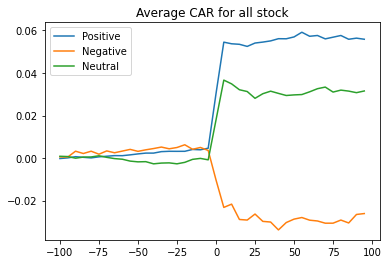

In [ ]:
plt.figure()
plt.plot(time_range,np.mean(all_CAR_pos,axis=0),label='Positive')
plt.plot(time_range,np.mean(all_CAR_neg,axis=0),label='Negative')
plt.plot(time_range,np.mean(all_CAR_neu,axis=0),label='Neutral')
plt.legend()
plt.title('Average CAR for all stock')
plt.show()

### 4.3.3. CAR by group of news
This part shows the CAR of all studied stocks based on each type of news

In [ ]:
begin_time=dt(2020,1,14)
end_time=dt(2020,5,2)
group_list=['Trial','Approval','Positive result','Negative result','Supply','Speculation','Side effects','Partnership','Other']
stock_twits_symbol_list=['GILD','REGN','ABBV','ABT','BCRX','BTI','PM','MO','TPB','NVAX','SNY']
intra_only=False

def get_plot_group(begin_time,end_time,group,intra_only):
  all_CAR=[]
  for symbol in stock_twits_symbol_list:
    CAR, news, df = get_CAR_group(begin_time,end_time,symbol,group,intra_only=intra_only)
    all_CAR = all_CAR + CAR
  all_CAR=np.array(all_CAR)
  mean_CAR = np.mean(all_CAR,axis=0)
  return all_CAR, mean_CAR 
  

#### Graphs of CAR by each group of news
1. For all the release about **trail news**, we can find there some news have obviously positive effect on the stock return, according to the first figure below.
2. For all the release about **approval news**, we can find there some news have obviously positive effect on the stock return, according to the second figure below.
3. For all the release about **positive result news**, we can find there some news have obviously positive effect on the stock return, and some of them have negative effect on the stock return also, according to our third figure below.
4. For **negative result news**, there are 6 news here, and 5 of them showed negative effect on the stock return.
5. For the release of news about **supply**, some of them showed positive effect on the stock return and some of them showed negative effect.
6. For the release of **speculation news**, there are 5 news here, and 4 of them showed positive effect on the stock return according to our sixth figure.
7. For the release of **side effect news**, some of them showed positive effect on stock return and some of them showed negative effect on the stock return.
8. For the release of **partnership news**, we have 3 news here, 2 showed positive effect on the stock return and 1 of them showed negative effect on the stock return.
9. For the release of **other news**, we have 3 news here, one showed positive effect on the stock return and one of them showed negative effect on the stock return.

  0%|          | 0/9 [00:00<?, ?it/s]

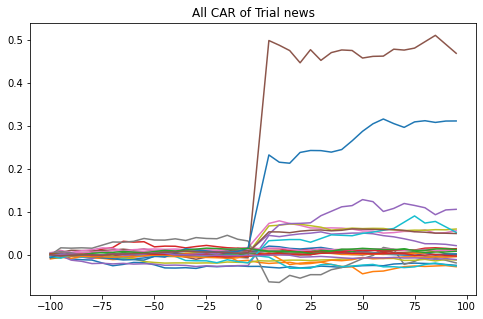

 11%|█         | 1/9 [00:01<00:09,  1.25s/it]

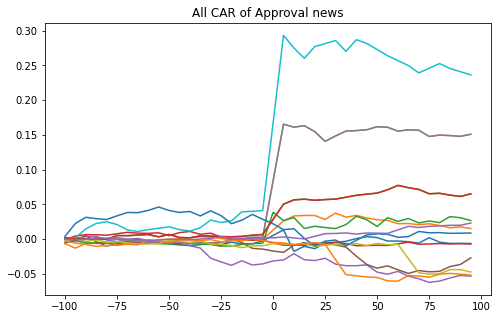

 22%|██▏       | 2/9 [00:02<00:08,  1.24s/it]

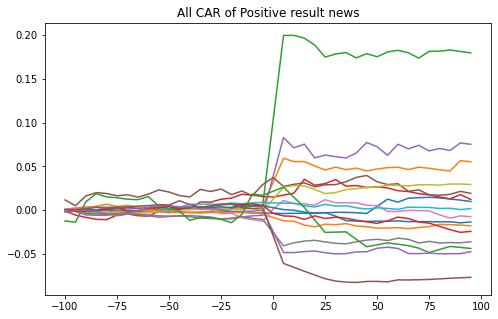

 33%|███▎      | 3/9 [00:03<00:07,  1.24s/it]

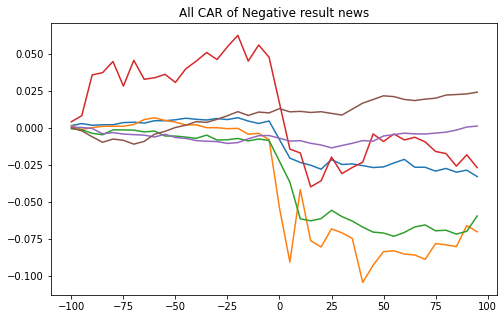

 44%|████▍     | 4/9 [00:04<00:06,  1.24s/it]

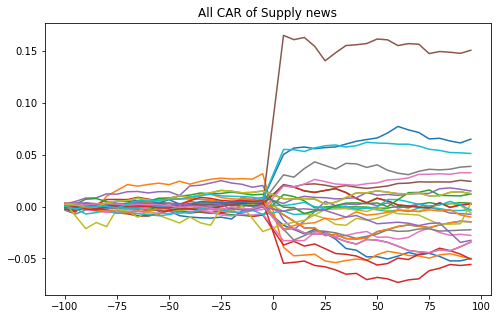

 56%|█████▌    | 5/9 [00:06<00:05,  1.26s/it]

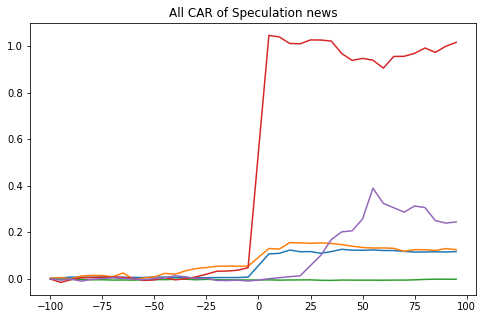

 67%|██████▋   | 6/9 [00:07<00:03,  1.25s/it]

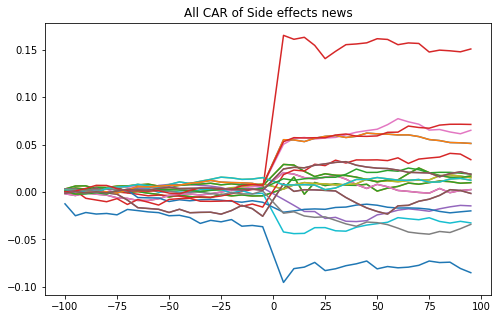

 78%|███████▊  | 7/9 [00:08<00:02,  1.25s/it]

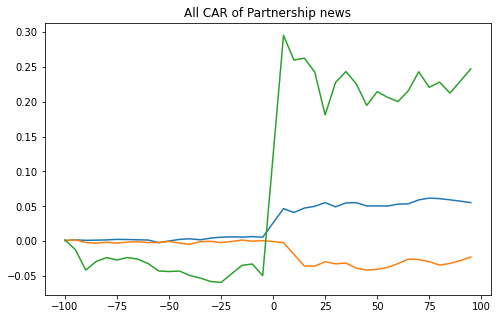

 89%|████████▉ | 8/9 [00:09<00:01,  1.23s/it]

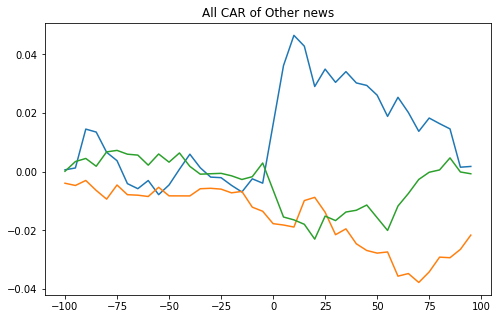

100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


In [ ]:
for group in tqdm(group_list):
  all_CAR, mean_CAR=get_plot_group(begin_time,end_time,group,intra_only=intra_only)
  
  plt.figure(figsize=(8, 5))
  plt.title('All CAR of {} news'.format(group))
  for i in range(len(all_CAR)):
    plt.plot(time_range,all_CAR[i])
  plt.show()


#### Average CAR by each group of news
For the average, as we can see from the figure below, **speculation,partnership, approval, trial, positive result, side effect** have positive effect on the stock return. **negative result** has negative effect on the stock return.

100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


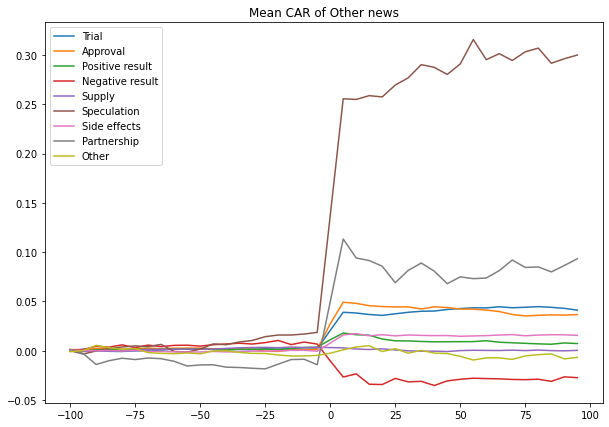

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Mean CAR of {} news'.format(group))
for group in tqdm(group_list):
  all_CAR, mean_CAR=get_plot_group(begin_time,end_time,group,intra_only=intra_only)
  try:  
    plt.plot(time_range,mean_CAR,label='{}'.format(group))
  except:
    pass
plt.legend()
plt.show()

## 5. Summary

We studied the impact of news published during trading hours on the return of the stock, and also studied the impact of the release of all relevant important news on the return of the stock. By comparing the two methods, we found that news releases does have an impact on the return of the relevant pharmaceutical companies' stocks in a short period of time. And also this kind of impact sometimes lasts a little bit long time.

## Reference
[1] Kurov, Alexander, Alessio Sancetta, Georg Strasser, and Marketa Halova Wolfe, 2015, [Price drift before U.S. macroeconomic news: Private information about public announcements?](https://https://www.ecb.europa.eu/pub/pdf/scpwps/ecbwp1901.en.pdf),West Virginia University, University of London, Boston College, and Washington State University.<br>
[2] Intraday event studies. https://www.eventstudytools.com/intraday-event-studies.<br>
[3] SIGNIFICANCE TESTS FOR EVENT STUDIES. https://www.eventstudytools.com/significance-tests <br>
[4] FDA. https://www.fda.gov/news-events/fda-newsroom/press-announcements <br>